In [ ]:
%%capture
import torch

# 1. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 2. KRİTİK ADIM: Xformers'ı Hazır Paket (Binary) Olarak Zorla Yükle
# Bu satır "Building wheels" hatasını engeller.
!pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps

# 3. Diğerlerini versiyon kontrolü yapmadan hızlıca kur
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
# ==========================================
# 🧪 KİMYA UZMANI - TAM EĞİTİM KODU
# ==========================================



# Gerekli Importlar
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
import shutil
import os
from google.colab import drive

# 2. DRIVE BAĞLANTISI
print("📂 Google Drive bağlanıyor...")
drive.mount('/content/drive')

# Dosya Yolları
# (Drive'daki dosyanın adı 'kimya_sorulari_fixed.json' ise burayı değiştirme)
source_file = "/content/drive/MyDrive/Proje_Yedekleri/kimya_sorulari_fixed.json"
local_file = "kimya_sorulari_fixed.json"

# Dosyayı Çek
if os.path.exists(source_file):
    shutil.copy(source_file, local_file)
    print(f"✅ Kimya Verisi Drive'dan Alındı: {local_file}")
else:
    print(f"❌ HATA: '{source_file}' bulunamadı! Lütfen dosya adını kontrol et.")

# 3. MODELİ YÜKLE
max_seq_length = 2048
model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

print(f"🔄 Model Yükleniyor: {model_name}...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)

# LoRA Ayarları
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

# 4. VERİ SETİNİ HAZIRLA
prompt_template = """Aşağıdaki kimya sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
{}
Doğru Cevap: {}""" + tokenizer.eos_token

def formatting_prompts_func(examples):
    questions = examples["question"]
    options_lists = examples["options"]
    rationales = examples["rationale"]
    corrects = examples["correct"]
    texts = []
    for q, opts, rat, corr in zip(questions, options_lists, rationales, corrects):
        # Liste kontrolü
        if not isinstance(opts, list):
            opts_str = str(opts) if opts is not None else ""
        else:
            try: opts_str = "\n".join([str(x) for x in opts])
            except: opts_str = str(opts)

        text = prompt_template.format(str(q), opts_str, str(rat), str(corr))
        texts.append(text)
    return { "text" : texts, }

print("♻️ Veri Seti Formatlanıyor...")
dataset = load_dataset("json", data_files={"train": local_file}, split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

# 5. EĞİTİMİ BAŞLAT
print("🚀 EĞİTİM BAŞLIYOR (A100)...")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        max_steps = 60, # Matematik ile aynı standart
        learning_rate = 2e-4,
        fp16 = False,
        bf16 = True,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

trainer_stats = trainer.train()

# 6. KAYDET
save_name = "model_kimya_uzmani"
print(f"💾 Model kaydediliyor: {save_name}...")
model.save_pretrained(save_name)
tokenizer.save_pretrained(save_name)

# 7. DRIVE'A YEDEKLE (Otomatik)
print("☁️ Drive'a Yedekleniyor...")
dest_path = f"/content/drive/MyDrive/Proje_Yedekleri/{save_name}"
if os.path.exists(dest_path):
    shutil.rmtree(dest_path) # Eskisi varsa sil
shutil.copytree(save_name, dest_path)

print("🎉 KİMYA MODELİ EĞİTİLDİ VE DRIVE'A YEDEKLENDİ!")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
📂 Google Drive bağlanıyor...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ HATA: '/content/drive/MyDrive/Proje_Yedekleri/kimya_sorulari_fixed.json' bulunamadı! Lütfen dosya adını kontrol et.
🔄

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


♻️ Veri Seti Formatlanıyor...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

🚀 EĞİTİM BAŞLIYOR (A100)...


Map (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yebalta86 (yebalta86-y-ld-z-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.766800
2,1.626500
3,1.806200
4,1.695700
5,1.811200
6,1.560300
7,1.438900
8,1.467300
9,1.218600
10,1.224500


💾 Model kaydediliyor: model_kimya_uzmani...
☁️ Drive'a Yedekleniyor...
🎉 KİMYA MODELİ EĞİTİLDİ VE DRIVE'A YEDEKLENDİ!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

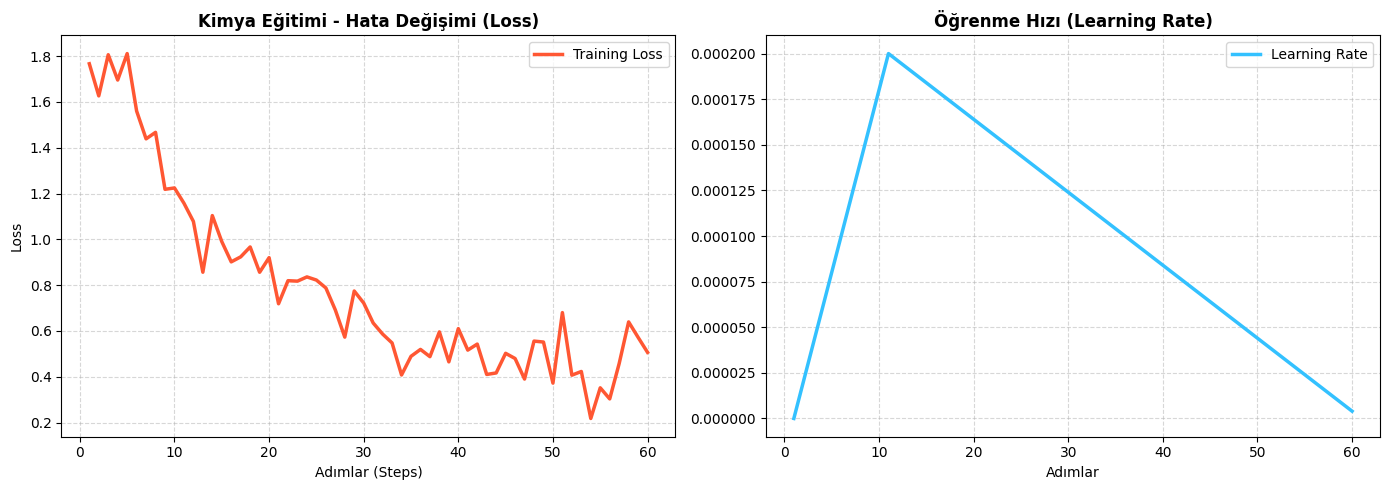

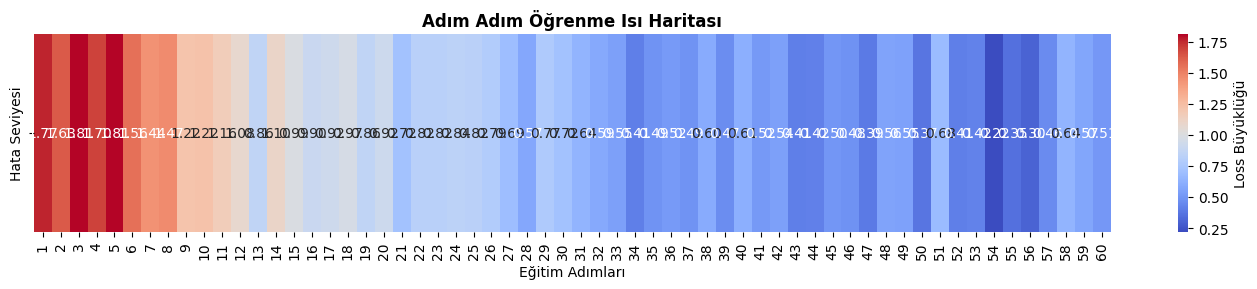

✅ Grafikler çizildi ve kaydedildi!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Eğitim Geçmişini Çek
try:
    history = trainer.state.log_history
    steps = []
    losses = []
    lr_values = []

    for log in history:
        if "loss" in log:
            steps.append(log["step"])
            losses.append(log["loss"])
            if "learning_rate" in log:
                lr_values.append(log["learning_rate"])

    # Veri Çerçevesi Oluştur
    df = pd.DataFrame({"Adım": steps, "Loss": losses})

    # ==========================================
    # 📊 GRAFİK 1: EĞİTİM PERFORMANSI (Çizgi)
    # ==========================================
    plt.figure(figsize=(14, 5))

    # Sol: Loss Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, label="Training Loss", color="#FF5733", linewidth=2.5)
    plt.title("Kimya Eğitimi - Hata Değişimi (Loss)", fontsize=12, fontweight='bold')
    plt.xlabel("Adımlar (Steps)")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Sağ: Learning Rate
    if lr_values:
        plt.subplot(1, 2, 2)
        plt.plot(steps, lr_values, label="Learning Rate", color="#33C1FF", linewidth=2.5)
        plt.title("Öğrenme Hızı (Learning Rate)", fontsize=12, fontweight='bold')
        plt.xlabel("Adımlar")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()

    plt.tight_layout()
    plt.savefig("kimya_egitim_grafigi.png", dpi=300)
    plt.show()

    # ==========================================
    # 🔥 GRAFİK 2: ISI HARİTASI (Heatmap)
    # ==========================================
    plt.figure(figsize=(14, 3))
    loss_matrix = np.array(losses).reshape(1, -1)

    sns.heatmap(loss_matrix,
                cmap="coolwarm",
                annot=True,
                fmt=".2f",
                xticklabels=steps,
                yticklabels=["Hata Seviyesi"],
                cbar_kws={'label': 'Loss Büyüklüğü'})

    plt.title("Adım Adım Öğrenme Isı Haritası", fontsize=12, fontweight='bold')
    plt.xlabel("Eğitim Adımları")
    plt.tight_layout()
    plt.savefig("kimya_heatmap.png", dpi=300)
    plt.show()

    print("✅ Grafikler çizildi ve kaydedildi!")

except NameError:
    print("❌ HATA: 'trainer' değişkeni bulunamadı. Oturumu kapatıp açtıysanız eğitim geçmişi silinmiş olabilir.")

BU KISIMDA T4 GPU YA GEÇİŞ YAPTIM.

In [ ]:
import os
import shutil
import torch
from google.colab import drive

print("🔵 ADIM 1: Kütüphaneler Kuruluyor (Yaklaşık 1-2 dk)...")
# Sessiz modda kurulum, ama hata varsa gösterir
op1 = os.system('pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"')
op2 = os.system('pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes')

if op1 == 0 and op2 == 0:
    print("✅ Kütüphaneler Hazır!")
else:
    print("⚠️ Kurulumda uyarılar olabilir ama devam ediliyor...")

# ---
print("\n🔵 ADIM 2: Dosyalar Drive'dan Getiriliyor...")
drive.mount('/content/drive')

drive_model_path = "/content/drive/MyDrive/Proje_Yedekleri/model_kimya_uzmani"
local_model = "model_kimya_uzmani"

if os.path.exists(drive_model_path):
    if os.path.exists(local_model):
        shutil.rmtree(local_model) # Temiz olsun diye eskisi varsa sil
    shutil.copytree(drive_model_path, local_model)
    print(f"✅ Model Başarıyla Kopyalandı: {local_model}")
else:
    print(f"❌ HATA: Model Drive'da bulunamadı! Yol: {drive_model_path}")
    print("Lütfen Drive'daki 'Proje_Yedekleri' klasörünü kontrol et.")
    # Kodu burada durdurmak lazım ama hata vermesin diye devam ettiriyoruz

# ---
print("\n🔵 ADIM 3: Model Hafızaya Yükleniyor (T4 GPU)...")
try:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = local_model,
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )
    FastLanguageModel.for_inference(model)
    print("✅ Model Yüklendi ve Hazır!")
except Exception as e:
    print(f"❌ Model Yükleme Hatası: {e}")

# ---
print("\n🔵 ADIM 4: Deneme Atışı (Test Sorusu)...")
prompt = """Aşağıdaki kimya sorusunu çöz.

### Soru:
1 mol H2O kaç gramdır? (H:1, O:16)

### Cevap:
"""

inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100, use_cache=True)
cevap = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

print("-" * 30)
print(cevap)
print("-" * 30)
print("🎉 Eğer yukarıda mantıklı bir kimya cevabı görüyorsan sistem çalışıyor demektir!")

🔵 ADIM 1: Kütüphaneler Kuruluyor (Yaklaşık 1-2 dk)...
⚠️ Kurulumda uyarılar olabilir ama devam ediliyor...

🔵 ADIM 2: Dosyalar Drive'dan Getiriliyor...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model Başarıyla Kopyalandı: model_kimya_uzmani

🔵 ADIM 3: Model Hafızaya Yükleniyor (T4 GPU)...
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✅ Model Yüklendi ve Hazır!

🔵 ADIM 4: Deneme Atışı (Test Sorusu)...
------------------------------
Aşağıdaki kimya sorusunu çöz.

### Soru:
1 mol H2O kaç gramdır? (H:1, O:16)

### Cevap:
1 mol H2O, 2 gram H ve 16 gram O içerir. 2+16 = 18 gramdır. Cevap 18 g’dir.
Doğru Cevap: B
------------------------------
🎉 Eğer yukarıda mantıklı bir kimya cevabı görüyorsan sistem çalışıyor demektir!


✅ Model zaten hafızada. Teste geçiliyor...
✂️ Dosyada 500 soru var. Rastgele 100 tanesi seçildi.
🚀 TEST BAŞLADI (Bu işlem 3-5 dakika sürebilir)...


Çözülüyor: 100%|██████████| 100/100 [14:38<00:00,  8.78s/it]



🧪 KİMYA SONUÇLARI
🏆 DOĞRULUK: %64.00


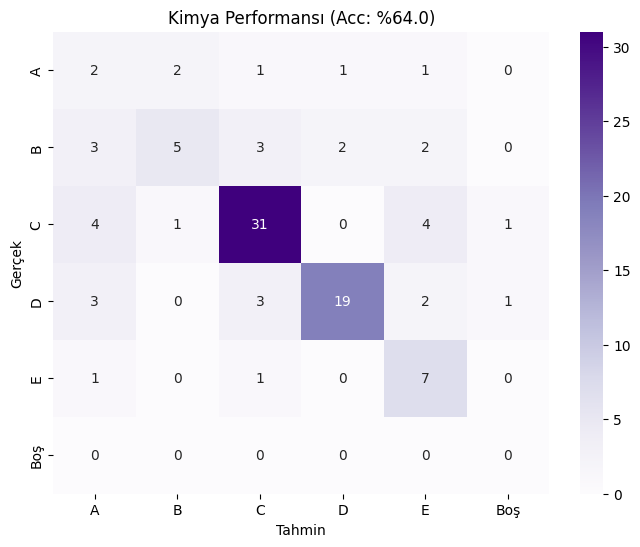

In [ ]:
import json
import torch
import re
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from unsloth import FastLanguageModel

# --- 1. AYARLAR ---
data_file = "kimya_sorulari_fixed.json" # Senin yüklediğin dosya
model_path = "model_kimya_uzmani"

# --- 2. MODEL KONTROLÜ ---
# Model zaten hafızadaysa tekrar yükleyip zaman kaybetmeyelim
try:
    if model:
        print("✅ Model zaten hafızada. Teste geçiliyor...")
except NameError:
    print("🔄 Model yükleniyor (Lütfen bekleyin)...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_path,
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )
    FastLanguageModel.for_inference(model)

# --- 3. VERİYİ YÜKLE VE SEÇ ---
try:
    with open(data_file, 'r', encoding='utf-8') as f:
        full_data = json.load(f)

    # Eğer 100'den fazla soru varsa rastgele 100 tane seç
    if len(full_data) > 100:
        random.seed(42)
        test_data = random.sample(full_data, 100)
        print(f"✂️ Dosyada {len(full_data)} soru var. Rastgele 100 tanesi seçildi.")
    else:
        test_data = full_data
        print(f"ℹ️ Tüm sorular ({len(full_data)} adet) test ediliyor.")

except FileNotFoundError:
    print(f"❌ HATA: '{data_file}' bulunamadı! Sol menüye yüklediğinden emin misin?")
    test_data = []

# --- 4. TEST FONKSİYONLARI ---
prompt_template = """Aşağıdaki kimya sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
"""

def extract_answer(text):
    match = re.search(r"Doğru Cevap:\s*([A-E])", text, re.IGNORECASE)
    if match: return match.group(1).upper()
    clean = text.strip()
    if clean and clean[-1].upper() in "ABCDE": return clean[-1].upper()
    return "Boş"

# --- 5. TEST DÖNGÜSÜ ---
y_true = []
y_pred = []

if test_data:
    print(f"🚀 TEST BAŞLADI (Bu işlem 3-5 dakika sürebilir)...")
    for item in tqdm(test_data, desc="Çözülüyor"):
        q = item.get("question")
        opts = item.get("options")
        corr = str(item.get("correct")).strip().upper()

        opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)

        input_text = prompt_template.format(q, opts_str)
        inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

        outputs = model.generate(**inputs, max_new_tokens=512, use_cache=True)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        ans = extract_answer(decoded.replace(input_text, ""))
        y_true.append(corr)
        y_pred.append(ans)

    # --- 6. SONUÇLAR ---
    if y_true:
        acc = accuracy_score(y_true, y_pred)
        print("\n" + "="*40)
        print(f"🧪 KİMYA SONUÇLARI")
        print("="*40)
        print(f"🏆 DOĞRULUK: %{acc*100:.2f}")

        # Grafik
        labels = ['A', 'B', 'C', 'D', 'E', 'Boş']
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
        plt.title(f'Kimya Performansı (Acc: %{acc*100:.1f})')
        plt.xlabel('Tahmin')
        plt.ylabel('Gerçek')
        plt.show()
    else:
        print("❌ Soru çözülemedi.")

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-795730363.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Yöntem', y='Başarı (%)', data=perf_data, ax=axes[1], palette=colors)
/tmp/ipython-input-795730363.py:57: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.savefig("kimya_performans_analizi.png", dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


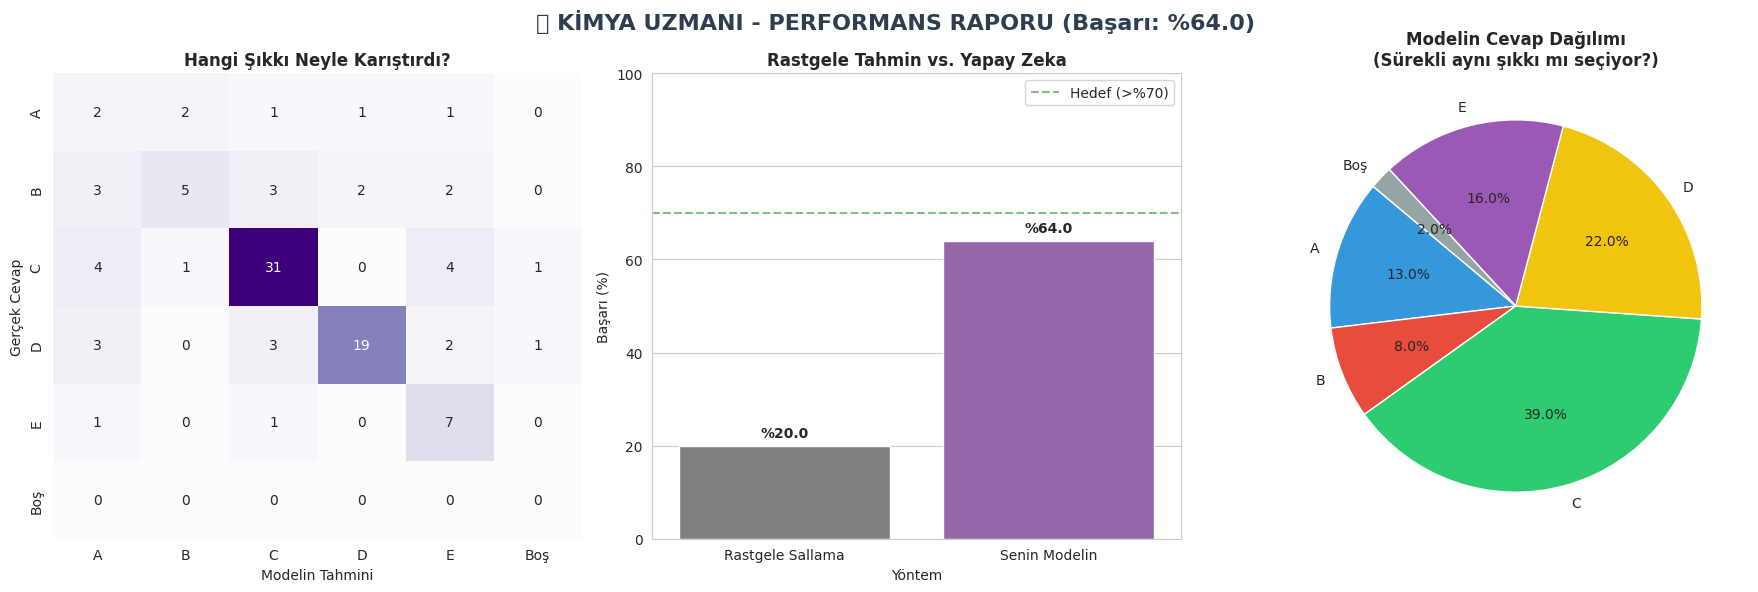

✅ Analiz tamamlandı! 'kimya_performans_analizi.png' olarak kaydedildi.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Veri Kontrolü: Test yapılmış mı?
if 'y_true' in locals() and 'y_pred' in locals() and len(y_true) > 0:

    # Genel Ayarlar
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = [18, 6]

    # Hesaplamalar
    acc = accuracy_score(y_true, y_pred) * 100
    labels = ['A', 'B', 'C', 'D', 'E', 'Boş']

    # 3'lü Grafik Çerçevesi Oluştur
    fig, axes = plt.subplots(1, 3)
    fig.suptitle(f'🧪 KİMYA UZMANI - PERFORMANS RAPORU (Başarı: %{acc:.1f})', fontsize=16, fontweight='bold', color='#2c3e50')

    # --- GRAFİK 1: Isı Haritası (Confusion Matrix) ---
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
                xticklabels=labels, yticklabels=labels, cbar=False)
    axes[0].set_title('Hangi Şıkkı Neyle Karıştırdı?', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Modelin Tahmini')
    axes[0].set_ylabel('Gerçek Cevap')

    # --- GRAFİK 2: Başarı Kıyaslaması (Bar Chart) ---
    perf_data = pd.DataFrame({
        'Yöntem': ['Rastgele Sallama', 'Senin Modelin'],
        'Başarı (%)': [20.0, acc]
    })
    colors = ['gray', '#9b59b6'] if acc > 20 else ['gray', 'red']

    barplot = sns.barplot(x='Yöntem', y='Başarı (%)', data=perf_data, ax=axes[1], palette=colors)
    axes[1].set_title('Rastgele Tahmin vs. Yapay Zeka', fontsize=12, fontweight='bold')
    axes[1].set_ylim(0, 100)
    axes[1].axhline(70, color='green', linestyle='--', alpha=0.5, label='Hedef (>%70)')
    axes[1].legend()

    # Çubukların üstüne değer yaz
    for p in barplot.patches:
        barplot.annotate(f'%{p.get_height():.1f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

    # --- GRAFİK 3: Modelin Şık Tercihleri (Pie Chart) ---
    pred_counts = pd.Series(y_pred).value_counts().reindex(labels, fill_value=0)
    colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6', '#95a5a6']

    axes[2].pie(pred_counts, labels=pred_counts.index, autopct='%1.1f%%', startangle=140, colors=colors_pie)
    axes[2].set_title('Modelin Cevap Dağılımı\n(Sürekli aynı şıkkı mı seçiyor?)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig("kimya_performans_analizi.png", dpi=300)
    plt.show()

    print("✅ Analiz tamamlandı! 'kimya_performans_analizi.png' olarak kaydedildi.")

else:
    print("❌ HATA: Önce test kodunu çalıştırmalısın! (y_true ve y_pred verileri bulunamadı)")

In [ ]:
import pandas as pd
import os
import shutil
from google.colab import drive

# 1. Drive Bağlantısı
drive.mount('/content/drive')

# 2. Kayıt Klasörü Oluştur
save_folder = "/content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari"
os.makedirs(save_folder, exist_ok=True)

print("💾 Kayıt İşlemi Başlıyor...")

# --- A. EXCEL RAPORU OLUŞTURMA ---
if 'test_data' in locals() and 'y_true' in locals():
    rapor_listesi = []

    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if i < len(test_data):
            soru_metni = test_data[i].get("question", "")
            secenekler = str(test_data[i].get("options", ""))

            rapor_listesi.append({
                "Soru No": i + 1,
                "Soru": soru_metni,
                "Seçenekler": secenekler,
                "Gerçek Cevap": true,
                "Model Tahmini": pred,
                "Durum": "✅ DOĞRU" if true == pred else "❌ YANLIŞ"
            })

    df = pd.DataFrame(rapor_listesi)
    excel_path = f"{save_folder}/Kimya_Detayli_Rapor.xlsx"
    df.to_excel(excel_path, index=False)

    print(f"   ✅ Excel Raporu Kaydedildi: {excel_path}")
else:
    print("   ⚠️ Veri bulunamadı (Testi çalıştırdığına emin misin?)")

# --- B. GRAFİĞİ KAYDETME ---
grafik_kaynak = "kimya_performans_analizi.png"
grafik_hedef = f"{save_folder}/Kimya_Grafik_Analizi.png"

if os.path.exists(grafik_kaynak):
    shutil.copy(grafik_kaynak, grafik_hedef)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
💾 Kayıt İşlemi Başlıyor...
   ✅ Excel Raporu Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/Kimya_Detayli_Rapor.xlsx
